In [1]:
import numpy as np
import pickle

# Load the data from the pickle file
file_path = "/home/maleen/research_data/Transformers/datasets/khoa_datasets/Khoa_01.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)

# Extract the arrays
timestamps1_og= data['timestamp']
skeleton_3d_frames1_og = data['points']
khoa_velocities_og = data['velocity']
khoa_accelerations_og = data['acceleration']

# Specify how many frames to trim from start and end
trim_start = 100  # Change this to the number of frames you want to remove from the start
trim_end = 100    # Change this to the number of frames you want to remove from the end

# Trim the arrays
timestamps1 = timestamps1_og[trim_start:-trim_end]
skeleton_3d_frames1 = skeleton_3d_frames1_og[trim_start:-trim_end,:, :]
khoa_velocities = khoa_velocities_og[trim_start:-trim_end, :, :]
khoa_accelerations = khoa_accelerations_og[trim_start:-trim_end,:, :]

# Print the shapes of the original and trimmed arrays to verify
print("Original shapes:")
print("Timestamps shape:", timestamps1_og.shape)
print("Points shape:", skeleton_3d_frames1_og.shape)
print("Velocities shape:", khoa_velocities_og.shape)
print("Accelerations shape:", khoa_velocities_og.shape)

print("\nTrimmed shapes:")
print("Timestamps shape:", timestamps1.shape)
print("Points shape:", skeleton_3d_frames1.shape)
print("Velocities shape:", khoa_velocities.shape)
print("Accelerations shape:", khoa_accelerations.shape)



Original shapes:
Timestamps shape: (6946, 1)
Points shape: (6946, 6, 3)
Velocities shape: (6946, 6, 3)
Accelerations shape: (6946, 6, 3)

Trimmed shapes:
Timestamps shape: (6746, 1)
Points shape: (6746, 6, 3)
Velocities shape: (6746, 6, 3)
Accelerations shape: (6746, 6, 3)


In [2]:
def calculate_velocity_acceleration(skeleton_3d_frames, timestamps):
    # Convert timestamps to float numpy array
    timestamps_float = np.array([float(t) for t in timestamps])
    
    # Calculate the differences in position and time
    position_diff = np.diff(skeleton_3d_frames, axis=0)
    time_diff = np.diff(timestamps_float)
    
    # Ensure that time_diff is of shape (n,1,1) so that it broadcasts correctly when dividing
    time_diff = time_diff[:, np.newaxis, np.newaxis]
    
    # Calculate velocity, handling missing data according to the mask
    # Where the mask is False, we will get np.nan
    skel_vel = position_diff / time_diff
    
    # Calculate the differences in velocity
    velocity_diff = np.diff(skel_vel, axis=0)
    
    # Calculate acceleration, handling missing data according to the mask
    # Where the mask is False, we will get np.nan
    skel_acc = velocity_diff / time_diff[:-1, :, :]  # Use time_diff with one less time dimension
    
    # Adjust positions and velocities to match acceleration's time steps
    skel_pos = skeleton_3d_frames[2:]
    skel_vel = skel_vel[1:]
    
    return skel_pos, skel_vel, skel_acc

In [3]:
datasets = [skeleton_3d_frames1] #, skeleton_3d_frames2, skeleton_3d_frames3, skeleton_3d_frames4, skeleton_3d_frames5, skeleton_3d_frames6]
timestamps_list = [timestamps1] #, timestamps2, timestamps3, timestamps4, timestamps5, timestamps6]

for i, (dataset, timestamps) in enumerate(zip(datasets, timestamps_list), 1):
    pos, vel, acc = calculate_velocity_acceleration(dataset, timestamps)
    
    # Create numpy arrays with names corresponding to the dataset
    exec(f"dataset{i}_pos = pos")
    exec(f"dataset{i}_vel = vel")
    exec(f"dataset{i}_acc = acc")

    print(f"Calculated for dataset{i}:")
    print(f"  Position shape: {eval(f'dataset{i}_pos').shape}")
    print(f"  Velocity shape: {eval(f'dataset{i}_vel').shape}")
    print(f"  Acceleration shape: {eval(f'dataset{i}_acc').shape}")
    print()

Calculated for dataset1:
  Position shape: (6744, 6, 3)
  Velocity shape: (6744, 6, 3)
  Acceleration shape: (6744, 6, 3)



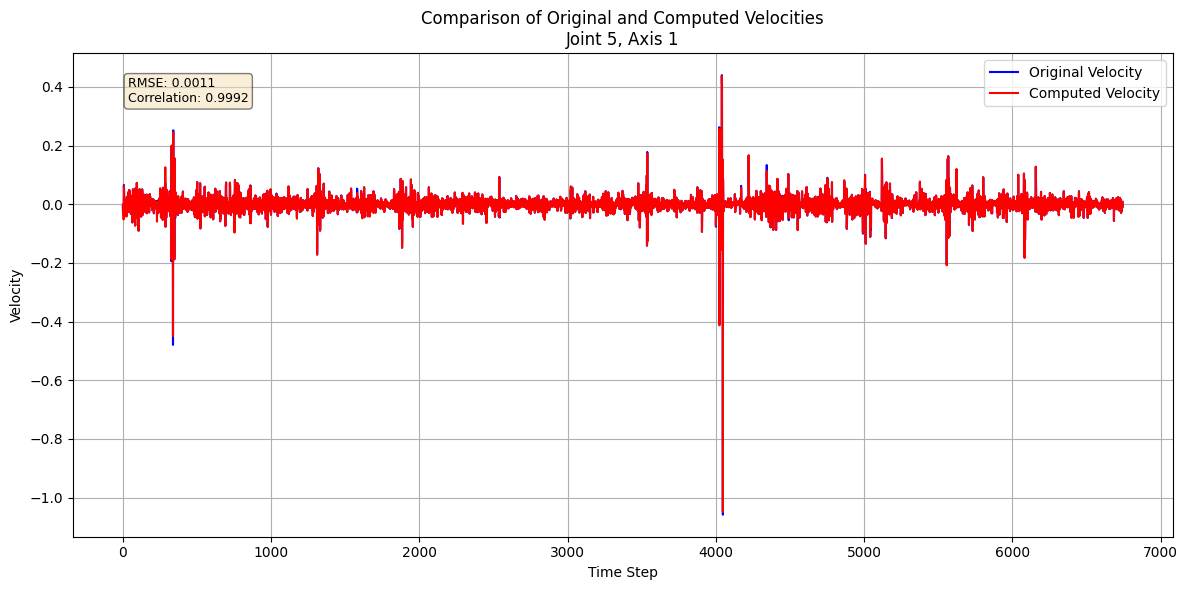

Plot saved as 'velocity_comparison.png'
RMSE between original and computed velocities: 0.0011
Correlation between original and computed velocities: 0.9992


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the velocity data
velocities = khoa_velocities[2:]  # The original dataset velocities
dataset1_vel = dataset1_vel # The computed velocities

# Choose a joint and axis to compare (e.g., joint 0, x-axis)
joint = 5
axis = 1

# Extract the velocities for the chosen joint and axis
original_vel = velocities[:, joint, axis]
computed_vel = dataset1_vel[:, joint, axis]

# Create a time array (assuming constant time steps)
time = np.arange(len(original_vel))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time, original_vel, label='Original Velocity', color='blue')
plt.plot(time, computed_vel, label='Computed Velocity', color='red')

plt.title(f'Comparison of Original and Computed Velocities\nJoint {joint}, Axis {axis}')
plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.legend()
plt.grid(True)

# Add text box with statistical comparison
rmse = np.sqrt(np.mean((original_vel - computed_vel)**2))
correlation = np.corrcoef(original_vel, computed_vel)[0, 1]
textstr = f'RMSE: {rmse:.4f}\nCorrelation: {correlation:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.savefig('velocity_comparison.png')
plt.show()

print(f"Plot saved as 'velocity_comparison.png'")
print(f"RMSE between original and computed velocities: {rmse:.4f}")
print(f"Correlation between original and computed velocities: {correlation:.4f}")

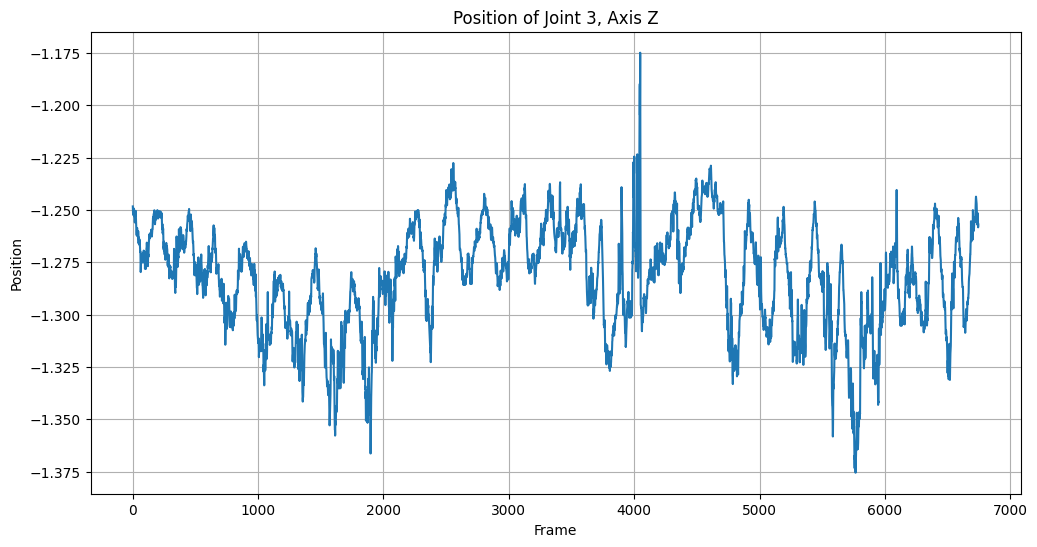

Plot saved as position_joint3_axisZ.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the position data
positions = skeleton_3d_frames1

# Specify the joint and axis you want to plot
joint = 3  # Change this to the joint you want to plot (0-5)
axis = 2   # Change this to the axis you want to plot (0 for X, 1 for Y, 2 for Z)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(positions[:, joint, axis])
plt.title(f'Position of Joint {joint}, Axis {["X", "Y", "Z"][axis]}')
plt.xlabel('Frame')
plt.ylabel('Position')
plt.grid(True)

# # Save the plot
# plt.savefig(f'position_joint{joint}_axis{["X", "Y", "Z"][axis]}.png')
plt.show()

print(f'Plot saved as position_joint{joint}_axis{["X", "Y", "Z"][axis]}.png')

In [6]:
import plotly.graph_objects as go
import numpy as np
from ipywidgets import interact, IntSlider, Layout
from IPython.display import display

def visualize_skeleton_3d(skeleton_data, timestamps):
    # Define the connections between joints for 6 points
    connections = [
        (0, 1), (1, 2),  # Right arm
        (3, 4), (4, 5),  # Left arm
        (2, 3),  # Connection between arms
    ]
    
    # Calculate the overall min and max for each axis
    x_min, y_min, z_min = np.min(skeleton_data, axis=(0, 1))
    x_max, y_max, z_max = np.max(skeleton_data, axis=(0, 1))
    
    # Add some padding to the min and max values
    padding = 0.1  # 10% padding
    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min
    x_min -= x_range * padding
    x_max += x_range * padding
    y_min -= y_range * padding
    y_max += y_range * padding
    z_min -= z_range * padding
    z_max += z_range * padding
    
    # Extend axes to negative values
    x_limit = max(abs(x_min), abs(x_max))
    y_limit = max(abs(y_min), abs(y_max))
    z_limit = max(abs(z_min), abs(z_max))
    
    def update_frame(frame):
        # Get the skeletal data for the current frame
        frame_data = skeleton_data[frame]
        
        # Create scatter plot for points
        scatter = go.Scatter3d(
            x=frame_data[:, 0], y=frame_data[:, 1], z=frame_data[:, 2],
            mode='markers',
            marker=dict(size=6, color='blue'),
            name='Joints'
        )
        
        # Create lines for connections
        lines = []
        for start, end in connections:
            lines.append(
                go.Scatter3d(
                    x=[frame_data[start, 0], frame_data[end, 0]],
                    y=[frame_data[start, 1], frame_data[end, 1]],
                    z=[frame_data[start, 2], frame_data[end, 2]],
                    mode='lines',
                    line=dict(color='red', width=2),
                    name=f'Connection {start}-{end}'
                )
            )
        
        # Combine scatter and lines
        data = [scatter] + lines
        
        # Create the layout with fixed axes and camera position
        layout = go.Layout(
            scene=dict(
                xaxis=dict(title='X', range=[-x_limit, x_limit], autorange=False),
                yaxis=dict(title='Y', range=[-y_limit, y_limit], autorange=False),
                zaxis=dict(title='Z', range=[-z_limit, z_limit], autorange=False),
                aspectmode='cube',  # This ensures the plot is a cube
                camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5),  # Adjust camera position
                up=dict(x=0, y=1, z=0)  # Set up direction to positive z-axis
                )
            ),
            title=f"Frame: {frame}, Timestamp: {timestamps[frame]}",
            height=700,  # Increase the height of the plot
            width=700    # Increase the width of the plot
        )
        
        # Create and show the figure
        fig = go.Figure(data=data, layout=layout)
        fig.show()
    
    # Create an interactive widget with a longer slider
    interact(
        update_frame,
        frame=IntSlider(
            min=0, 
            max=len(skeleton_data)-1, 
            step=1, 
            value=0, 
            description='Frame:',
            style={'description_width': 'initial'},
            layout=Layout(width='1250px')  # This makes the slider longer
        )
    )

# Assuming interpolated_skeletal_data is your numpy array of shape (frames, 6, 3)
# and skeleton_timestamps is your array of timestamps
visualize_skeleton_3d(skeleton_3d_frames1, timestamps1)

interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='1250px'), max=6745, style=…

In [7]:
def robust_normalize_data_with_clipping(data, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]
            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(joint_axis_data, clipping_percentiles)
            # Clip the data based on thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)
            # Normalize the clipped data, avoiding division by zero
            if iqrs_per_joint_axis[joint, axis] > 0:
                normalized_values = (clipped_values - medians_per_joint_axis[joint, axis]) / iqrs_per_joint_axis[joint, axis]
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0
            # Store the normalized values
            normalized_data[:, joint, axis] = normalized_values
    return normalized_data

def calculate_combined_statistics(data_list):
    combined_data = np.concatenate(data_list, axis=0)
    medians = np.median(combined_data, axis=0)
    q75, q25 = np.percentile(combined_data, [75, 25], axis=0)
    iqrs = q75 - q25
    return medians, iqrs

def process_datasets_with_combined_normalization(datasets, timestamps_list):
    results = {}
    pos_list, vel_list, acc_list = [], [], []

    # First pass: calculate velocity and acceleration for each dataset
    for i, (dataset, timestamps) in enumerate(zip(datasets, timestamps_list), 1):
        pos, vel, acc = calculate_velocity_acceleration(dataset, timestamps)
        pos_list.append(pos)
        vel_list.append(vel)
        acc_list.append(acc)

    # Calculate combined statistics
    medians_pos, iqrs_pos = calculate_combined_statistics(pos_list)
    medians_vel, iqrs_vel = calculate_combined_statistics(vel_list)
    medians_acc, iqrs_acc = calculate_combined_statistics(acc_list)

    # Second pass: normalize each dataset using the combined statistics
    for i, (pos, vel, acc) in enumerate(zip(pos_list, vel_list, acc_list), 1):
        norm_pos = np.empty_like(pos)
        norm_vel = np.empty_like(vel)
        norm_acc = np.empty_like(acc)

        norm_pos = robust_normalize_data_with_clipping(pos, medians_pos, iqrs_pos, norm_pos)
        norm_vel = robust_normalize_data_with_clipping(vel, medians_vel, iqrs_vel, norm_vel)
        norm_acc = robust_normalize_data_with_clipping(acc, medians_acc, iqrs_acc, norm_acc)

        results[f"dataset{i}_normpos"] = norm_pos
        results[f"dataset{i}_normvel"] = norm_vel
        results[f"dataset{i}_normacc"] = norm_acc

        print(f"Calculated and normalized for dataset{i}:")
        print(f"  Position shape: {norm_pos.shape}")
        print(f"  Velocity shape: {norm_vel.shape}")
        print(f"  Acceleration shape: {norm_acc.shape}")
        print()

    # Store the combined statistics
    results["combined_medians_pos"] = medians_pos
    results["combined_iqrs_pos"] = iqrs_pos
    results["combined_medians_vel"] = medians_vel
    results["combined_iqrs_vel"] = iqrs_vel
    results["combined_medians_acc"] = medians_acc
    results["combined_iqrs_acc"] = iqrs_acc

    return results

# Usage example

results = process_datasets_with_combined_normalization(datasets, timestamps_list)

Calculated and normalized for dataset1:
  Position shape: (6744, 6, 3)
  Velocity shape: (6744, 6, 3)
  Acceleration shape: (6744, 6, 3)



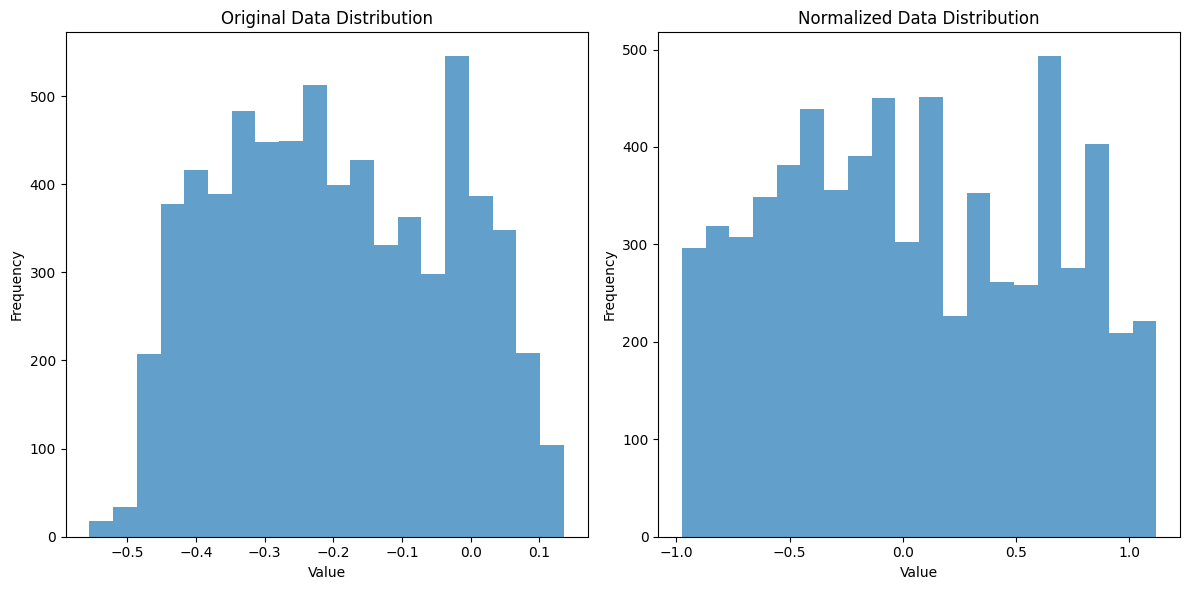

Median of normalized data: -2.6630005e-08
Data points within [-3, 3] (IQR): 6744 out of 6744
Original Data points within [-3, 3] (IQR): 6744 out of 6744


In [12]:
data=dataset1_pos
norm_data=results["dataset1_normpos"]
# Plot the original and normalized data for a specific joint and axis
joint, axis = 0, 0  # Change as needed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data[:, joint, axis], bins=20, alpha=0.7, label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(norm_data[:, joint, axis], bins=20, alpha=0.7, label='Normalized')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the median and range of the normalized data
normalized_median = np.nanmedian(norm_data[:, joint, axis])
print("Median of normalized data:", normalized_median)

within_iqr = ((norm_data[:, joint, axis] > -3) & (norm_data[:, joint, axis] < 3)).sum()
print(f"Data points within [-3, 3] (IQR): {within_iqr} out of {norm_data.shape[0]}")

within_iqr2 = ((data[:, joint, axis] > -3) & (data[:, joint, axis] < 3)).sum()
print(f"Original Data points within [-3, 3] (IQR): {within_iqr2} out of {norm_data.shape[0]}")

In [9]:
results

{'dataset1_normpos': array([[[-0.58832276, -0.79175305, -1.1061779 ],
         [-0.3112379 , -0.5547668 , -1.2559563 ],
         [-0.10398611, -0.55290127, -0.8816126 ],
         [ 0.38706002, -0.28568083,  0.7577604 ],
         [ 0.5182673 ,  0.19507581, -0.23908892],
         [-0.01294122,  0.04500774,  0.37766248]],
 
        [[-0.58387136, -0.7956078 , -1.1182187 ],
         [-0.30649838, -0.566674  , -1.2690635 ],
         [-0.1258254 , -0.59727776, -0.8691193 ],
         [ 0.37681308, -0.3591388 ,  0.743975  ],
         [ 0.45335084,  0.01442284, -0.20657162],
         [-0.04358868, -0.13365479,  0.3442445 ]],
 
        [[-0.5694632 , -0.7922213 , -1.1267929 ],
         [-0.30202413, -0.55479497, -1.2878598 ],
         [-0.16685022, -0.55481815, -0.84840846],
         [ 0.33624423, -0.3562979 ,  0.76462066],
         [ 0.4237424 , -0.00782088, -0.16962034],
         [-0.07817621, -0.20463416,  0.32837808]],
 
        ...,
 
        [[-0.8177924 , -0.28398708, -0.89420176],
      

In [10]:

def save_results_to_pickle(results, filename):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

#Add to the training DIC instead of new dic?

unnormalised = {
    "dataset1_pos": dataset1_pos,
    "dataset1_vel": dataset1_vel,
    "dataset1_acc": dataset1_acc,
    
    # "dataset2_pos": dataset2_pos,
    # "dataset2_vel": dataset2_vel,
    # "dataset2_acc": dataset2_acc,
    
    # "dataset3_pos": dataset3_pos,
    # "dataset3_vel": dataset3_vel,
    # "dataset3_acc": dataset3_acc,
    
    # "dataset4_pos": dataset4_pos,
    # "dataset4_vel": dataset4_vel,
    # "dataset4_acc": dataset4_acc,
    
    # "dataset5_pos": dataset5_pos,
    # "dataset5_vel": dataset5_vel,
    # "dataset5_acc": dataset5_acc,
    
    # "dataset6_pos": dataset6_pos,
    # "dataset6_vel": dataset6_vel,
    # "dataset6_acc": dataset6_acc,
}

datapath="/home/maleen/research_data/Transformers/datasets/khoa_datasets/"
process_date="24_08_29"

# Usage
filename1 = datapath + process_date + '_training_raw.pkl'
filename2 = datapath + process_date + '_training_norm.pkl'

# # Save the results
save_results_to_pickle(unnormalised, filename1)
print(f"Results saved to {filename1}")
save_results_to_pickle(results, filename2)
print(f"Results saved to {filename2}")



Results saved to /home/maleen/research_data/Transformers/datasets/khoa_datasets/24_08_29_training_raw.pkl
Results saved to /home/maleen/research_data/Transformers/datasets/khoa_datasets/24_08_29_training_norm.pkl
